In [1]:
import pandas as pd

df = pd.read_excel("DailyProd.xlsx")
df.columns = df.columns.str.strip()  # loại bỏ khoảng trắng đầu/cuối
print("Tên các cột:", df.columns.tolist())
print("\n5 dòng đầu tiên:")
print(df.head())

Tên các cột: ['Date', 'Status', 'WorkingHour', 'ChokeSize', 'WHFP', 'WHFT', 'Liquid_Daily Prod', 'Liquid_Daily Rate', 'Liquid_Cum', 'Oil_Daily Prod', 'Oil_Daily Rate', 'Oil_Cum', 'Gas_Daily Prod', 'Gas_Daily Rate', 'Gas_Cum', 'Water_Daily Prod', 'Water_Daily Rate', 'Water_Cum', 'GOR', 'Water Cut', 'BHFP', 'Gaslift', 'Column1']

5 dòng đầu tiên:
        Date Status  WorkingHour  ChokeSize        WHFP  WHFT  \
0 2015-04-24      P         24.0         40  677.761350   NaN   
1 2015-04-25      P         24.0         40  668.623972   NaN   
2 2015-04-26      P         24.0         40  660.646897   NaN   
3 2015-04-27      P         24.0         40  654.555312   NaN   
4 2015-04-28      P         24.0         40  645.417934   NaN   

   Liquid_Daily Prod  Liquid_Daily Rate  Liquid_Cum  Oil_Daily Prod  ...  \
0        2040.086339        2040.086339    0.002040     2040.086339  ...   
1        2086.907417        2086.907417    0.004127     2086.907417  ...   
2        1944.497169        1944.4

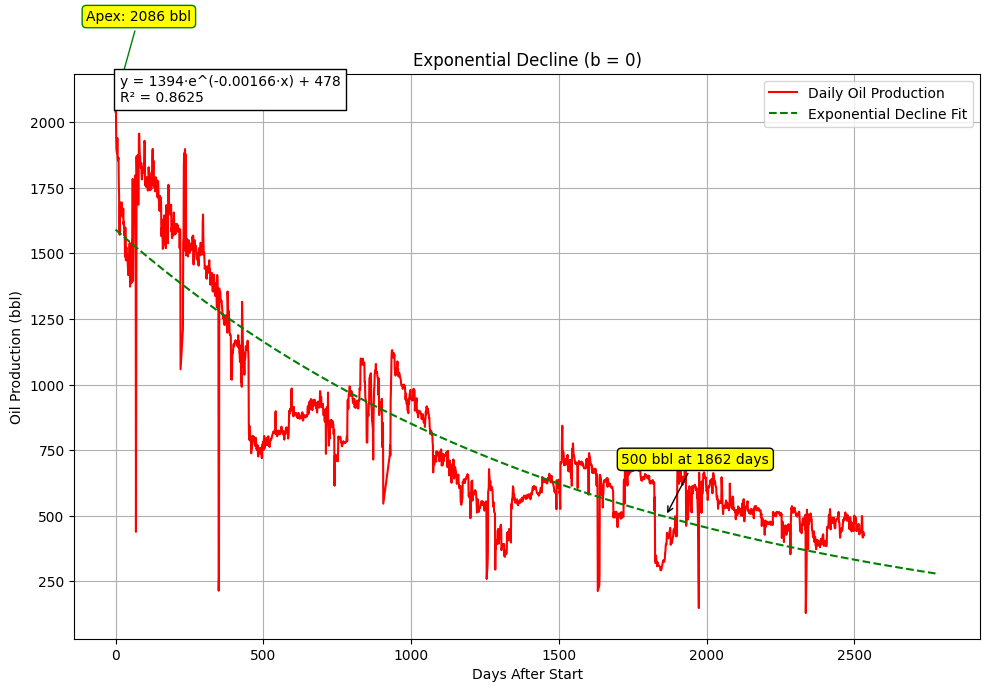


📊 Kết quả fitting:
qi = 1590.69, Di = 0.2285, b = 0.00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Hàm decline với b = 0 (hàm mũ)
def exponential_decline(t, qi, Di):
    return qi * np.exp(-Di * t)

# Hàm để biểu diễn lại phương trình với offset nếu cần
def exponential_func(t, a, b, c):
    return a * np.exp(-b * t) + c

# Hàm fitting và vẽ
def perform_exponential_dca(t_data, q_data):
    initial_guess = [q_data[0], 0.5]

    try:
        popt, _ = curve_fit(exponential_decline, t_data, q_data, p0=initial_guess, bounds=(0, np.inf))
        qi_fit, Di_fit = popt
    except RuntimeError:
        raise RuntimeError("Fitting thất bại với mô hình exponential (b = 0)")

    t_fit = np.linspace(0, max(t_data) * 1.1, 200)
    q_fit = exponential_decline(t_fit, qi_fit, Di_fit)

    t_days = t_data * 365.25
    t_fit_days = t_fit * 365.25

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 7))
    plt.plot(t_days, q_data, color='red', label='Daily Oil Production')
    plt.plot(t_fit_days, q_fit, 'g--', label='Exponential Decline Fit')

    # Đỉnh
    apex_idx = np.argmax(q_data)
    apex_val = q_data[apex_idx]
    apex_time = t_days[apex_idx]
    plt.annotate(f"Apex: {int(apex_val)} bbl", xy=(apex_time, apex_val),
                 xytext=(apex_time - 100, apex_val + 300),
                 arrowprops=dict(arrowstyle='->', color='green'),
                 bbox=dict(boxstyle="round", fc="yellow", ec="green"))

    # Phương trình + R²
    try:
        exp_popt, _ = curve_fit(exponential_func, t_days, q_data, p0=[q_data[0], 0.005, 100])
        a, b, c = exp_popt
        y_pred = exponential_func(t_days, a, b, c)
        r2 = 1 - np.sum((q_data - y_pred) ** 2) / np.sum((q_data - np.mean(q_data)) ** 2)
        plt.text(0.05, 0.95,
                 f"y = {a:.0f}·e^(-{b:.5f}·x) + {c:.0f}\nR² = {r2:.4f}",
                 transform=plt.gca().transAxes, fontsize=10,
                 bbox=dict(facecolor='white', edgecolor='black'))
    except:
        pass

    # Dấu mốc 500 bbl
    target_q = 500
    for t_val, q_val in zip(t_fit_days, q_fit):
        if q_val <= target_q:
            plt.annotate(f"{target_q} bbl at {int(t_val)} days", xy=(t_val, target_q),
                         xytext=(t_val - 150, target_q + 200),
                         arrowprops=dict(arrowstyle='->'),
                         bbox=dict(boxstyle="round", fc="yellow"))
            break

    plt.xlabel("Days After Start")
    plt.ylabel("Oil Production (bbl)")
    plt.title("Exponential Decline (b = 0)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return qi_fit, Di_fit

# === Main ===
file_path = "DailyProd.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# Xác định cột thời gian và cột sản lượng dầu
time_col = "Date"
rate_col = "Oil_Daily Prod"

# Chuẩn hóa dữ liệu
t_raw = df[time_col]
q_data = df[rate_col].values

# Chuyển đổi thời gian sang năm kể từ ngày đầu tiên
if np.issubdtype(t_raw.dtype, np.datetime64):
    start_date = t_raw.min()
    t_data = (t_raw - start_date).dt.days / 365.25
else:
    t_data = t_raw.values

# Fitting
qi_fit, Di_fit = perform_exponential_dca(t_data, q_data)

print(f"\n📊 Kết quả fitting:")
print(f"qi = {qi_fit:.2f}, Di = {Di_fit:.4f}, b = 0.00")


C:\Users\Admin\AppData\Local\Temp\ipykernel_16004\3103924390.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cumulative_production = np.trapz(q_fit, t_fit) * 365.25  # Chuyển từ năm sang ngày


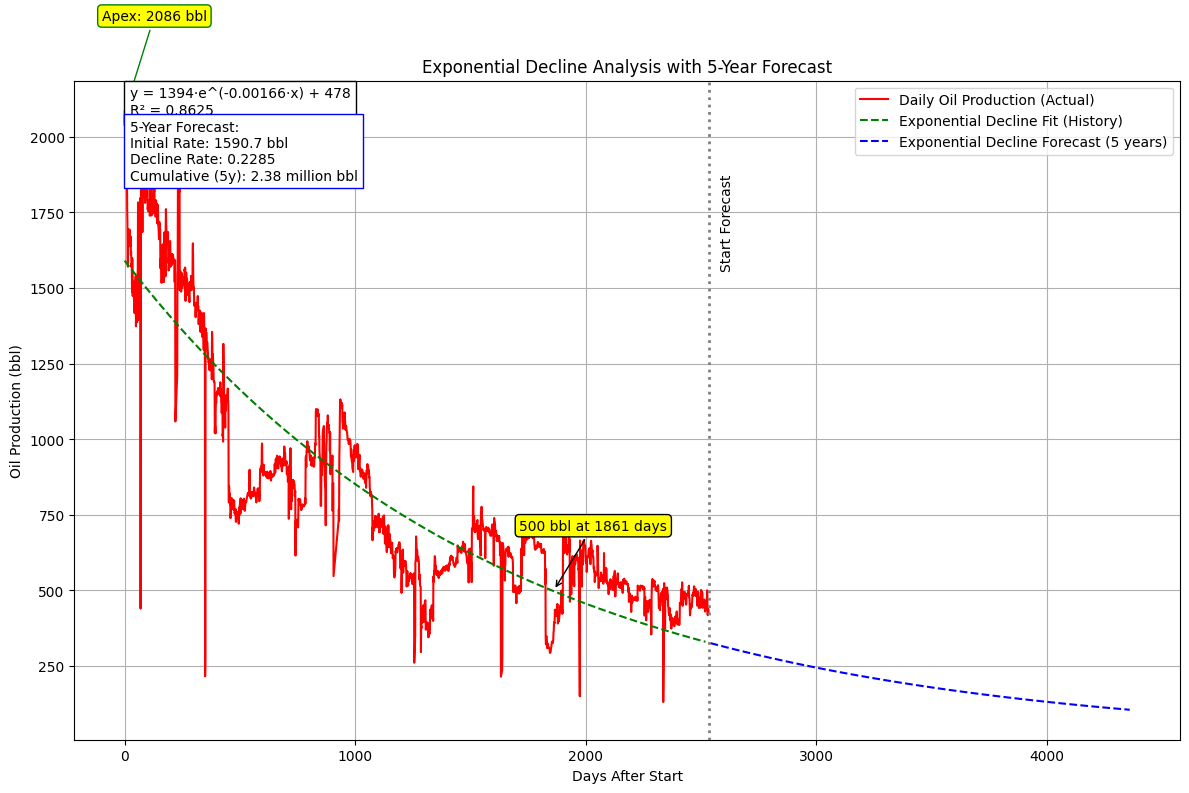


📊 Kết quả fitting và dự báo:
qi = 1590.69, Di = 0.2285, b = 0.00

📈 Dự báo sản lượng cho 5 năm tiếp theo:
      Năm        Ngày  Sản lượng dự báo (bbl)
 6.957071 2541.070352              324.548802
 7.017046 2562.976131              320.132004
 7.077021 2584.881910              315.775314
 7.136996 2606.787688              311.477915
 7.196970 2628.693467              307.238999
 7.256945 2650.599246              303.057771
 7.316920 2672.505025              298.933445
 7.376895 2694.410804              294.865248
 7.436869 2716.316583              290.852415
 7.496844 2738.222362              286.894192
 7.556819 2760.128141              282.989837
 7.616794 2782.033920              279.138617
 7.676769 2803.939698              275.339808
 7.736743 2825.845477              271.592697
 7.796718 2847.751256              267.896581
 7.856693 2869.657035              264.250765
 7.916668 2891.562814              260.654566
 7.976642 2913.468593              257.107307
 8.036617 2935.3743

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Hàm decline với b = 0 (hàm mũ)
def exponential_decline(t, qi, Di):
    return qi * np.exp(-Di * t)

# Hàm để biểu diễn lại phương trình với offset nếu cần
def exponential_func(t, a, b, c):
    return a * np.exp(-b * t) + c

# Hàm fitting, vẽ và dự báo 5 năm
def perform_exponential_dca(t_data, q_data, forecast_years=5):
    initial_guess = [q_data[0], 0.5]

    try:
        popt, _ = curve_fit(exponential_decline, t_data, q_data, p0=initial_guess, bounds=(0, np.inf))
        qi_fit, Di_fit = popt
    except RuntimeError:
        raise RuntimeError("Fitting thất bại với mô hình exponential (b = 0)")

    # Mở rộng thời gian để bao gồm 5 năm dự báo
    t_max = max(t_data)
    t_fit = np.linspace(0, t_max + forecast_years, 200)
    q_fit = exponential_decline(t_fit, qi_fit, Di_fit)

    t_days = t_data * 365.25
    t_fit_days = t_fit * 365.25

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 8))
    
    # Vẽ dữ liệu thực tế
    plt.plot(t_days, q_data, color='red', label='Daily Oil Production (Actual)')
    
    # Vẽ đường fitting (phần lịch sử)
    plt.plot(t_fit_days[t_fit <= t_max], q_fit[t_fit <= t_max], 'g--', label='Exponential Decline Fit (History)')
    
    # Vẽ phần dự báo (5 năm tiếp theo)
    plt.plot(t_fit_days[t_fit > t_max], q_fit[t_fit > t_max], 'b--', label=f'Exponential Decline Forecast ({forecast_years} years)')
    
    # Thêm đường phân cách giữa lịch sử và dự báo
    plt.axvline(x=max(t_days), color='gray', linestyle=':', linewidth=2)
    plt.text(max(t_days)+50, max(q_data)*0.9, 'Start Forecast', rotation=90, va='top')

    # Đỉnh
    apex_idx = np.argmax(q_data)
    apex_val = q_data[apex_idx]
    apex_time = t_days[apex_idx]
    plt.annotate(f"Apex: {int(apex_val)} bbl", xy=(apex_time, apex_val),
                 xytext=(apex_time - 100, apex_val + 300),
                 arrowprops=dict(arrowstyle='->', color='green'),
                 bbox=dict(boxstyle="round", fc="yellow", ec="green"))

    # Phương trình + R²
    try:
        exp_popt, _ = curve_fit(exponential_func, t_days, q_data, p0=[q_data[0], 0.005, 100])
        a, b, c = exp_popt
        y_pred = exponential_func(t_days, a, b, c)
        r2 = 1 - np.sum((q_data - y_pred) ** 2) / np.sum((q_data - np.mean(q_data)) ** 2)
        plt.text(0.05, 0.95,
                 f"y = {a:.0f}·e^(-{b:.5f}·x) + {c:.0f}\nR² = {r2:.4f}",
                 transform=plt.gca().transAxes, fontsize=10,
                 bbox=dict(facecolor='white', edgecolor='black'))
    except:
        pass

    # Dấu mốc 500 bbl
    target_q = 500
    for t_val, q_val in zip(t_fit_days, q_fit):
        if q_val <= target_q:
            plt.annotate(f"{target_q} bbl at {int(t_val)} days", xy=(t_val, target_q),
                         xytext=(t_val - 150, target_q + 200),
                         arrowprops=dict(arrowstyle='->'),
                         bbox=dict(boxstyle="round", fc="yellow"))
            break

    # Tính toán sản lượng tích lũy
    cumulative_production = np.trapz(q_fit, t_fit) * 365.25  # Chuyển từ năm sang ngày
    plt.text(0.05, 0.85, 
             f"5-Year Forecast:\nInitial Rate: {qi_fit:.1f} bbl\nDecline Rate: {Di_fit:.4f}\nCumulative (5y): {cumulative_production/1e6:.2f} million bbl",
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', edgecolor='blue'))

    plt.xlabel("Days After Start")
    plt.ylabel("Oil Production (bbl)")
    plt.title(f"Exponential Decline Analysis with {forecast_years}-Year Forecast")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return qi_fit, Di_fit, q_fit[t_fit > t_max], t_fit[t_fit > t_max]

# === Main ===
file_path = "DailyProd.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# Xác định cột thời gian và cột sản lượng dầu
time_col = "Date"
rate_col = "Oil_Daily Prod"

# Chuẩn hóa dữ liệu
t_raw = df[time_col]
q_data = df[rate_col].values

# Chuyển đổi thời gian sang năm kể từ ngày đầu tiên
if np.issubdtype(t_raw.dtype, np.datetime64):
    start_date = t_raw.min()
    t_data = (t_raw - start_date).dt.days / 365.25
else:
    t_data = t_raw.values

# Fitting và dự báo 5 năm
qi_fit, Di_fit, q_forecast, t_forecast = perform_exponential_dca(t_data, q_data, forecast_years=5)

# In kết quả dự báo
print(f"\n📊 Kết quả fitting và dự báo:")
print(f"qi = {qi_fit:.2f}, Di = {Di_fit:.4f}, b = 0.00")
print("\n📈 Dự báo sản lượng cho 5 năm tiếp theo:")
forecast_df = pd.DataFrame({
    'Năm': t_forecast,
    'Ngày': t_forecast * 365.25,
    'Sản lượng dự báo (bbl)': q_forecast
})
print(forecast_df.to_string(index=False))


📊 KẾT QUẢ PHÂN TÍCH SUY GIẢM
----------------------------
❶ Thông số fitting:
- Sản lượng ban đầu (qi): 1590.69 bbl
- Hệ số suy giảm (Di): 0.2285
- Tốc độ suy giảm: 22.85%/năm

📈 DỰ BÁO SẢN LƯỢNG 5 NĂM TIẾP THEO
----------------------------------
  Năm   Số ngày  Sản lượng dự báo (bbl)
Năm 1  8.070352              324.548802
Năm 2 29.976131              320.132004
Năm 3 51.881910              315.775314
Năm 4 73.787688              311.477915
Năm 5 95.693467              307.238999


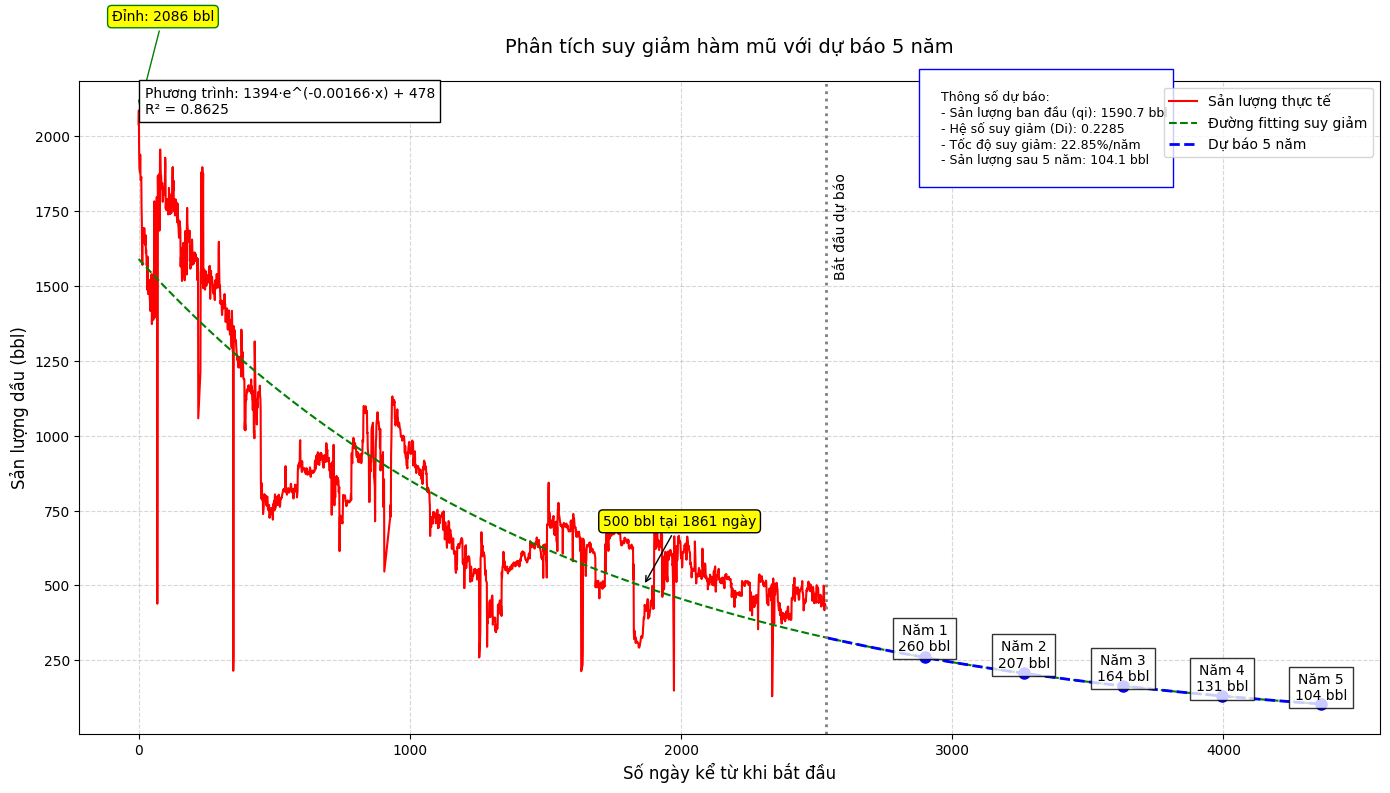

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import FuncFormatter

# Hàm decline với b = 0 (hàm mũ)
def exponential_decline(t, qi, Di):
    return qi * np.exp(-Di * t)

# Hàm để biểu diễn lại phương trình với offset nếu cần
def exponential_func(t, a, b, c):
    return a * np.exp(-b * t) + c

# Hàm fitting, vẽ và dự báo 5 năm
def perform_exponential_dca(t_data, q_data, forecast_years=5):
    initial_guess = [q_data[0], 0.5]

    try:
        popt, _ = curve_fit(exponential_decline, t_data, q_data, p0=initial_guess, bounds=(0, np.inf))
        qi_fit, Di_fit = popt
    except RuntimeError:
        raise RuntimeError("Fitting thất bại với mô hình exponential (b = 0)")

    # Mở rộng thời gian để bao gồm 5 năm dự báo
    t_max = max(t_data)
    t_fit = np.linspace(0, t_max + forecast_years, 200)
    q_fit = exponential_decline(t_fit, qi_fit, Di_fit)

    t_days = t_data * 365.25
    t_fit_days = t_fit * 365.25

    # Tạo figure với kích thước lớn hơn
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    # Vẽ dữ liệu thực tế
    plt.plot(t_days, q_data, color='red', markersize=5, label='Sản lượng thực tế')
    
    # Vẽ đường fitting (toàn bộ)
    plt.plot(t_fit_days, q_fit, 'g--', label='Đường fitting suy giảm')
    
    # Phân biệt phần lịch sử và dự báo bằng màu sắc
    plt.plot(t_fit_days[t_fit > t_max], q_fit[t_fit > t_max], 'b--', linewidth=2, 
             label=f'Dự báo {forecast_years} năm')
    
    # Thêm đường phân cách và chú thích
    plt.axvline(x=max(t_days), color='gray', linestyle=':', linewidth=2)
    plt.text(max(t_days)+30, max(q_data)*0.9, 'Bắt đầu dự báo', rotation=90, va='top')

    # Đánh dấu các mốc thời gian quan trọng trong dự báo
    for year in range(1, forecast_years+1):
        target_time = t_max + year
        q_val = exponential_decline(target_time, qi_fit, Di_fit)
        t_day = target_time * 365.25
        
        plt.plot(t_day, q_val, 'bo', markersize=8)
        plt.text(t_day, q_val*1.05, 
                 f'Năm {year}\n{q_val:.0f} bbl', 
                 ha='center', va='bottom', 
                 bbox=dict(facecolor='white', alpha=0.8))

    # Đỉnh sản lượng
    apex_idx = np.argmax(q_data)
    apex_val = q_data[apex_idx]
    apex_time = t_days[apex_idx]
    plt.annotate(f"Đỉnh: {int(apex_val)} bbl", xy=(apex_time, apex_val),
                 xytext=(apex_time - 100, apex_val + 300),
                 arrowprops=dict(arrowstyle='->', color='green'),
                 bbox=dict(boxstyle="round", fc="yellow", ec="green"))

    # Phương trình + R²
    try:
        exp_popt, _ = curve_fit(exponential_func, t_days, q_data, p0=[q_data[0], 0.005, 100])
        a, b, c = exp_popt
        y_pred = exponential_func(t_days, a, b, c)
        r2 = 1 - np.sum((q_data - y_pred) ** 2) / np.sum((q_data - np.mean(q_data)) ** 2)
        plt.text(0.05, 0.95,
                 f"Phương trình: {a:.0f}·e^(-{b:.5f}·x) + {c:.0f}\nR² = {r2:.4f}",
                 transform=ax.transAxes, fontsize=10,
                 bbox=dict(facecolor='white', edgecolor='black'))
    except:
        pass

    # Mốc 500 bbl
    target_q = 500
    for t_val, q_val in zip(t_fit_days, q_fit):
        if q_val <= target_q:
            plt.annotate(f"{target_q} bbl tại {int(t_val)} ngày", xy=(t_val, target_q),
                         xytext=(t_val - 150, target_q + 200),
                         arrowprops=dict(arrowstyle='->'),
                         bbox=dict(boxstyle="round", fc="yellow"))
            break

    # Thông tin dự báo chi tiết
    forecast_info = f"""
    Thông số dự báo:
    - Sản lượng ban đầu (qi): {qi_fit:.1f} bbl
    - Hệ số suy giảm (Di): {Di_fit:.4f}
    - Tốc độ suy giảm: {Di_fit*100:.2f}%/năm
    - Sản lượng sau {forecast_years} năm: {q_fit[-1]:.1f} bbl
    """
    plt.text(0.65, 0.85, forecast_info, transform=ax.transAxes, 
             fontsize=9, bbox=dict(facecolor='white', edgecolor='blue'))

    # Định dạng đồ thị
    ax.set_xlabel("Số ngày kể từ khi bắt đầu", fontsize=12)
    ax.set_ylabel("Sản lượng dầu (bbl)", fontsize=12)
    ax.set_title(f"Phân tích suy giảm hàm mũ với dự báo {forecast_years} năm", fontsize=14, pad=20)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    plt.tight_layout()
    
    return qi_fit, Di_fit, q_fit[t_fit > t_max], t_fit[t_fit > t_max]

# === Main ===
file_path = "DailyProd.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# Xác định cột thời gian và cột sản lượng dầu
time_col = "Date"
rate_col = "Oil_Daily Prod"

# Chuẩn hóa dữ liệu
t_raw = df[time_col]
q_data = df[rate_col].values

# Chuyển đổi thời gian sang năm kể từ ngày đầu tiên
if np.issubdtype(t_raw.dtype, np.datetime64):
    start_date = t_raw.min()
    t_data = (t_raw - start_date).dt.days / 365.25
else:
    t_data = t_raw.values

# Fitting và dự báo 5 năm
qi_fit, Di_fit, q_forecast, t_forecast = perform_exponential_dca(t_data, q_data, forecast_years=5)

# In kết quả dự báo chi tiết
print("\n📊 KẾT QUẢ PHÂN TÍCH SUY GIẢM")
print("----------------------------")
print(f"❶ Thông số fitting:")
print(f"- Sản lượng ban đầu (qi): {qi_fit:.2f} bbl")
print(f"- Hệ số suy giảm (Di): {Di_fit:.4f}")
print(f"- Tốc độ suy giảm: {Di_fit*100:.2f}%/năm")

print("\n📈 DỰ BÁO SẢN LƯỢNG 5 NĂM TIẾP THEO")
print("----------------------------------")
forecast_df = pd.DataFrame({
    'Năm': [f"Năm {i+1}" for i in range(5)],
    'Số ngày': (t_forecast[:5] - max(t_data)) * 365.25,
    'Sản lượng dự báo (bbl)': q_forecast[:5]
})
print(forecast_df.to_string(index=False))

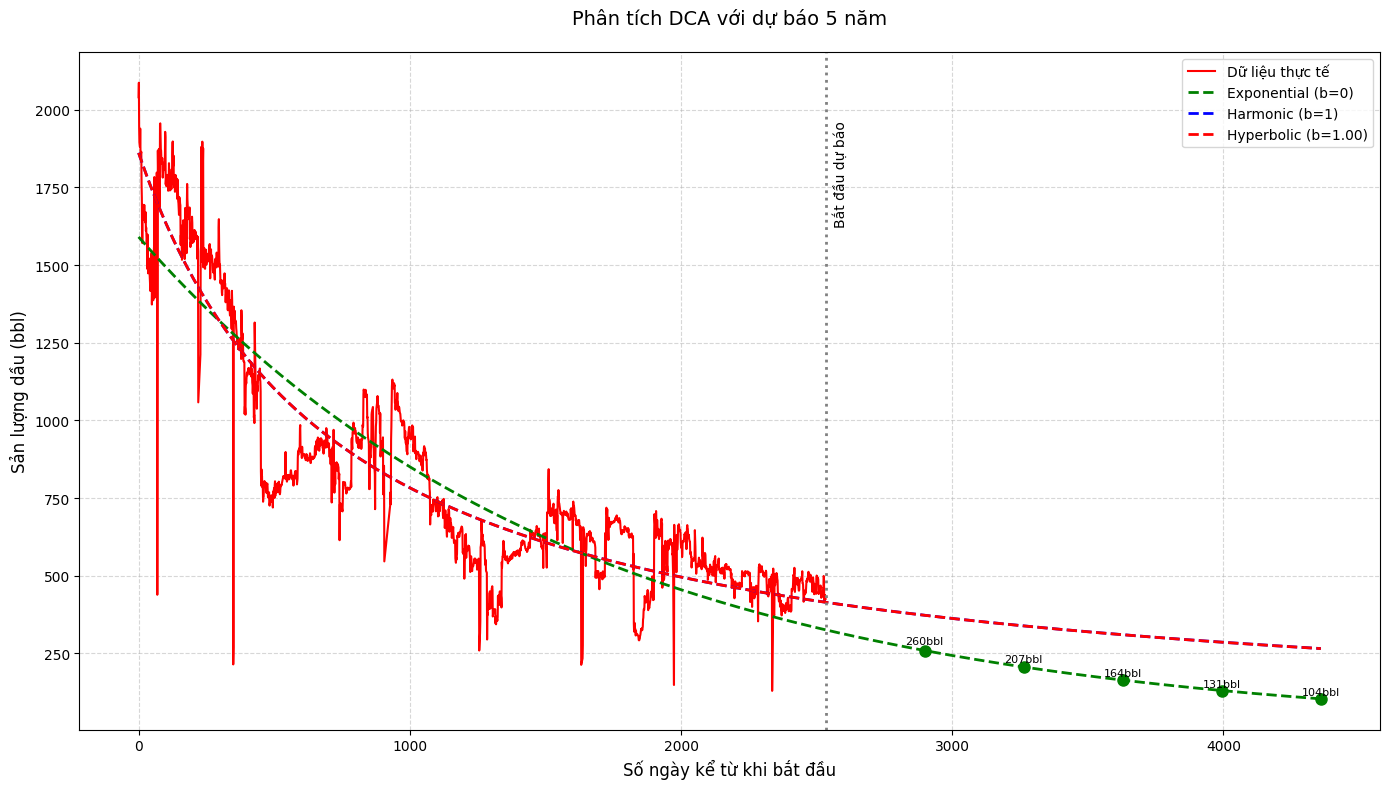


✅ Đã lưu kết quả DCA vào file: DCA_Results\DCA_Forecast_20251029_175919.xlsx

📊 BÁO CÁO KẾT QUẢ DCA

► EXPONENTIAL MODEL:
- Sản lượng ban đầu (qi): 1590.69 bbl
- Hệ số suy giảm (Di): 0.2285 1/năm
- Hệ số b: 0.00
- Độ chính xác (R²): 0.7987
- Sai số trung bình bình phương (RMSE): 170.89 bbl
- Sản lượng tích lũy 5năm: 2.38 triệu bbl

► HARMONIC MODEL:
- Sản lượng ban đầu (qi): 1861.38 bbl
- Hệ số suy giảm (Di): 0.5027 1/năm
- Hệ số b: 1.00
- Độ chính xác (R²): 0.8568
- Sai số trung bình bình phương (RMSE): 144.15 bbl
- Sản lượng tích lũy 5năm: 2.63 triệu bbl

► HYPERBOLIC MODEL:
- Sản lượng ban đầu (qi): 1861.13 bbl
- Hệ số suy giảm (Di): 0.5023 1/năm
- Hệ số b: 1.00
- Độ chính xác (R²): 0.8568
- Sai số trung bình bình phương (RMSE): 144.15 bbl
- Sản lượng tích lũy 5năm: 2.63 triệu bbl

📈 DỰ BÁO MẪU (5 ĐIỂM ĐẦU):
       Days                          Date  Exponential    Harmonic  Hyperbolic
   0.000000 2015-04-24 00:00:00.000000000  1590.693074 1861.383179 1861.129549
 874.765886 2017-0

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime

# === CÁC HÀM MÔ HÌNH SUY GIẢM ===
def exponential_decline(t, qi, Di):
    """Mô hình suy giảm hàm mũ (b=0)"""
    return qi * np.exp(-Di * t)

def harmonic_decline(t, qi, Di):
    """Mô hình suy giảm điều hòa (b=1)"""
    return qi / (1 + Di * t)

def hyperbolic_decline(t, qi, Di, b):
    """Mô hình suy giảm hyperbol (0<b<1)"""
    return qi / np.power(1 + b * Di * t, 1/b)

# === HÀM LƯU KẾT QUẢ DỰ BÁO ===
def save_dca_forecast(models, forecast_df, output_folder='DCA_Results'):
    """
    Lưu kết quả DCA ra file Excel với nhiều sheet
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = os.path.join(output_folder, f'DCA_Forecast_{timestamp}.xlsx')
    
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # Sheet dữ liệu dự báo
        forecast_df.to_excel(writer, sheet_name='Forecast', index=False)
        
        # Sheet thông số mô hình
        params_data = []
        for model, params in models.items():
            params_data.append({
                'Model': model,
                'qi (bbl)': params['qi'],
                'Di (1/year)': params['Di'],
                'b': params['b'],
                'R²': params['R2'],
                'RMSE': params['RMSE'], 
                'Cumulative (bbl)': params['CUM']
            })
        
        pd.DataFrame(params_data).to_excel(writer, sheet_name='Parameters', index=False)
        
        # Sheet đánh giá mô hình
        evaluation = pd.DataFrame({
            'Metric': ['Best Fit (Highest R²)', 'Most Conservative', 'Most Optimistic'],
            'Model': [
                max(models.items(), key=lambda x: x[1]['R2'])[0],
                min(models.items(), key=lambda x: x[1]['CUM'])[0],
                max(models.items(), key=lambda x: x[1]['CUM'])[0]
        ]})
        evaluation.to_excel(writer, sheet_name='Model Evaluation', index=False)
    
    print(f"\n✅ Đã lưu kết quả DCA vào file: {output_file}")
    return output_file

# === HÀM CHÍNH PHÂN TÍCH DCA ===
def perform_dca_analysis(t_data, q_data, start_date=None, forecast_years=5):
    """
    Thực hiện phân tích DCA với 3 mô hình và dự báo
    """
    # Tiền xử lý dữ liệu
    t_data = np.array(t_data)
    q_data = np.array(q_data)
    valid = (~np.isnan(q_data)) & (q_data > 0)
    t_data = t_data[valid]
    q_data = q_data[valid]
    
    # Khởi tạo kết quả
    models = {}
    t_max = max(t_data)
    t_fit = np.linspace(0, t_max + forecast_years, 300)
    t_fit_days = t_fit * 365.25
    t_days = t_data * 365.25
    
    # Tạo DataFrame dự báo
    forecast_df = pd.DataFrame({'Days': t_fit_days})
    if start_date is not None:
        forecast_df['Date'] = start_date + pd.to_timedelta(t_fit_days, unit='D')
    
    # === VẼ BIỂU ĐỒ ===
    plt.figure(figsize=(14, 8))
    plt.plot(t_days, q_data, markersize=5, label='Dữ liệu thực tế', color = "Red")
    
    # === MÔ HÌNH EXPONENTIAL ===
    try:
        popt, _ = curve_fit(exponential_decline, t_data, q_data, 
                           p0=[q_data[0], 0.5], bounds=(0, np.inf))
        qi, Di = popt
        q_fit = exponential_decline(t_fit, qi, Di)
        r2 = 1 - np.sum((q_data - exponential_decline(t_data, qi, Di))**2) / np.sum((q_data - np.mean(q_data))**2)
        rmse = np.sqrt(np.mean((q_data - exponential_decline(t_data, qi, Di))**2))
        cum = np.trapezoid(q_fit, t_fit) * 365.25
        
        models['Exponential'] = {'qi': qi, 'Di': Di, 'b': 0, 'R2': r2, 'RMSE': rmse, 'CUM': cum}
        forecast_df['Exponential'] = q_fit
        plt.plot(t_fit_days, q_fit, 'g--', linewidth=2, label='Exponential (b=0)')
        
        # Đánh dấu các năm dự báo
        for year in range(1, forecast_years+1):
            t_year = t_max + year
            q_year = exponential_decline(t_year, qi, Di)
            plt.plot(t_year*365.25, q_year, 'go', markersize=8)
            plt.text(t_year*365.25, q_year*1.05, f'{q_year:.0f}bbl', 
                    ha='center', va='bottom', fontsize=8)
    except Exception as e:
        print(f"❌ Exponential fitting failed: {str(e)}")
    
    # === MÔ HÌNH HARMONIC ===
    try:
        popt, _ = curve_fit(harmonic_decline, t_data, q_data, 
                           p0=[q_data[0], 0.01], bounds=(0, np.inf))
        qi, Di = popt
        q_fit = harmonic_decline(t_fit, qi, Di)
        r2 = 1 - np.sum((q_data - harmonic_decline(t_data, qi, Di))**2) / np.sum((q_data - np.mean(q_data))**2)
        rmse = np.sqrt(np.mean((q_data - harmonic_decline(t_data, qi, Di))**2))  
        cum = np.trapezoid(q_fit, t_fit) * 365.25
        
        models['Harmonic'] = {'qi': qi, 'Di': Di, 'b': 1, 'R2': r2, 'RMSE': rmse, 'CUM': cum}
        forecast_df['Harmonic'] = q_fit
        plt.plot(t_fit_days, q_fit, 'b--', linewidth=2, label='Harmonic (b=1)')
    except Exception as e:
        print(f"❌ Harmonic fitting failed: {str(e)}")
    
    # === MÔ HÌNH HYPERBOLIC ===
    try:
        popt, _ = curve_fit(hyperbolic_decline, t_data, q_data, 
                           p0=[q_data[0], 0.01, 0.5], bounds=(0, [np.inf, np.inf, 0.999]))
        qi, Di, b = popt
        q_fit = hyperbolic_decline(t_fit, qi, Di, b)
        r2 = 1 - np.sum((q_data - hyperbolic_decline(t_data, qi, Di, b))**2) / np.sum((q_data - np.mean(q_data))**2)
        rmse = np.sqrt(np.mean((q_data - harmonic_decline(t_data, qi, Di))**2))  
        cum = np.trapezoid(q_fit, t_fit) * 365.25
        
        models['Hyperbolic'] = {'qi': qi, 'Di': Di, 'b': b, 'R2': r2, 'RMSE': rmse, 'CUM': cum}
        forecast_df['Hyperbolic'] = q_fit
        plt.plot(t_fit_days, q_fit, 'r--', linewidth=2, label=f'Hyperbolic (b={b:.2f})')
    except Exception as e:
        print(f"❌ Hyperbolic fitting failed: {str(e)}")
    
    # === TRANG TRÍ BIỂU ĐỒ ===
    plt.axvline(x=max(t_days), color='gray', linestyle=':', linewidth=2)
    plt.text(max(t_days)+30, plt.ylim()[1]*0.9, 'Bắt đầu dự báo', rotation=90, va='top')
    
    plt.xlabel('Số ngày kể từ khi bắt đầu', fontsize=12)
    plt.ylabel('Sản lượng dầu (bbl)', fontsize=12)
    plt.title(f'Phân tích DCA với dự báo {forecast_years} năm', fontsize=14, pad=20)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # === LƯU KẾT QUẢ ===
    excel_path = save_dca_forecast(models, forecast_df)
    
    # === IN KẾT QUẢ ===
    print("\n📊 BÁO CÁO KẾT QUẢ DCA")
    print("="*50)
    for model, params in models.items():
        print(f"\n► {model.upper()} MODEL:")
        print(f"- Sản lượng ban đầu (qi): {params['qi']:.2f} bbl")
        print(f"- Hệ số suy giảm (Di): {params['Di']:.4f} 1/năm")
        print(f"- Hệ số b: {params['b']:.2f}")
        print(f"- Độ chính xác (R²): {params['R2']:.4f}")
        print(f"- Sai số trung bình bình phương (RMSE): {params['RMSE']:.2f} bbl")
        print(f"- Sản lượng tích lũy {forecast_years}năm: {params['CUM']/1e6:.2f} triệu bbl")
    
    print("\n📈 DỰ BÁO MẪU (5 ĐIỂM ĐẦU):")
    print(forecast_df.iloc[::60, :].head().to_string(index=False))  # Hiển thị mỗi năm 1 điểm
    
    return models, forecast_df, excel_path

# === PHẦN CHÍNH ===
if __name__ == "__main__":
    # Đọc dữ liệu
    file_path = "DailyProd.xlsx"
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip()
    
    # Xác định cột dữ liệu
    time_col = "Date"
    rate_col = "Oil_Daily Prod"
    
    # Tiền xử lý
    t_raw = df[time_col]
    q_data = df[rate_col].values
    
    # Chuyển đổi thời gian
    if np.issubdtype(t_raw.dtype, np.datetime64):
        start_date = t_raw.min()
        t_data = (t_raw - start_date).dt.days / 365.25
    else:
        t_data = t_raw.values
        start_date = None
    
    # Chạy phân tích DCA
    models, forecast_df, excel_path = perform_dca_analysis(t_data, q_data, start_date, forecast_years=5)